# 常见解码策略（Huggingface中实现的解码策略[4]）

Huggingface如何判断采用那种解码策略呢？如果直接使用model.generate()，就是上述参数的组合，会用来一一判断使用那种解码策略，如果出现冲突会抛出异常。目前Huggingface总共有8种解码策略，我们从Huggingface的判断顺序来说起：

# 1.constrained beam-search decoding

受限束搜索解码，使用model.generate()当 constraints 不为 None 或 force_words_ids不为 None 时进入该模式，而且要求num_beams要大于1（本质还是束搜索），do_sample为False，num_beam_groups为1，否则就会抛出：

In [ ]:
"`num_beams` needs to be greater than 1 for constrained generation."
"`do_sample` needs to be false for constrained generation."
"`num_beam_groups` not supported yet for constrained generation."

在这个解码策略中，核心还是上述实现的beam search，只不过在search中加入了我们提供的词表，强制其生成我们提供的词表，我们来看一下怎么使用，先来看一下传统的beam search使用：

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch
model_name = "llama-2-7b-hf" # 你模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")

# generate实现
generation_output = model.generate(
    input_ids=input_ids,
    num_beams = 3,
    num_return_sequences=3,
    return_dict_in_generate=True,
    max_new_tokens=3,
)

print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 结果
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to your new favorite
Generated sequence 2: say hello to your new best
Generated sequence 3: say hello to our newest

加上了约束之后，即我们给定词表["my"]：

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch
model_name = "llama-2-7b-hf" # 你模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")

force_words = ["my"]
force_words_ids = tokenizer(force_words, add_special_tokens=False).input_ids

generation_output = model.generate(
    input_ids=input_ids,
    force_words_ids = force_words_ids,
    num_beams = 3,
    num_return_sequences=3,
    return_dict_in_generate=True,
    max_new_tokens=3,
)

print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 结果    
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to my little friend
Generated sequence 2: say hello to your new favorite
Generated sequence 3: say hello to your new my

结果很明显，生成中出现了我们的限制词表“my”。

# 2.contrastive search

对比搜索策略，在model.generate()中，当 penalty_alpha 大于 0 且top_k>1大于 1 时使用，这是一种引入对比度惩罚的搜索方法，我们之前没有介绍过penalty_alpha这个惩罚因子参数，因为只有在contrastive search是才会用到。这种解码策略是在2022年A Contrastive Framework for Neural Text Generation[5]论文中提出来的方法，具体细节可以看论文，Huggingface已经实现，我们来看一下简单的原理：生成的token应该是从模型预测的最佳候选（top k）中而来；在生成token时，当前token应该能与前面生成的内容保持对比性（或差异性），其实现就是若当前生成的token 与之前的序列token相似度很大，就减少其整体概率值，进而减少它被解码出来的可能性，避免重复解码的问题。

核心公式如下：
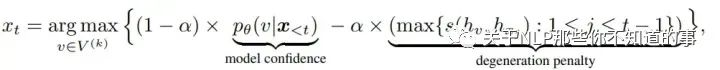

公式解读[6]：

其中
是token
候选集合，是根据模型
预测的top-k tokens，k一般取值3~10；上述公式表示要生成的
来自
集合中概率最大的那个token；每个候选token
的概率计算分两部分：1）
为模型预测的概率，可以保证一定流畅性；2）
为token
跟之前生成的序列token相似度中取最大的那个值。

核心实现代码如下：

In [ ]:
def ranking(context_hidden, next_hidden, next_top_k_ids, next_top_k_probs, alpha):
    '''
       该函数是实现Contrastive Search中next token预测中候选token的排序分数，分数最大对应token为输出结果
        context_hidden: beam_width x context_len x embed_dim ,用于计算相似度，是公式中x_j集合表征向量
        next_hidden: beam_width x 1 x embed_dim，用于计算相似度，是公式中候选token v 的表征向量
        next_top_k_ids: beam_width x 1，记录候选token的编码
        next_top_k_probs，候选token的模型预测概率
        alpha，惩罚参数
    '''
    beam_width, context_len, embed_dim = context_hidden.size()
    assert next_hidden.size() == torch.Size([beam_width, 1, embed_dim])
    norm_context_hidden = context_hidden / context_hidden.norm(dim=2, keepdim=True) 
    norm_next_hidden = next_hidden / next_hidden.norm(dim=2, keepdim=True)
    cosine_matrix = torch.matmul(norm_context_hidden, norm_next_hidden.transpose(1,2)).squeeze(-1) #计算相似度矩阵
    assert cosine_matrix.size() == torch.Size([beam_width, context_len])
    scores, _ = torch.max(cosine_matrix, dim = -1) #输出公式第二项值
    assert scores.size() == torch.Size([beam_width])
    next_top_k_probs = next_top_k_probs.view(-1)  #输出公式第一项值
    scores = (1.0 - alpha) * next_top_k_probs - alpha * scores  #对应公式整体计算
    _, selected_idx = torch.topk(scores, k = 1)
    assert selected_idx.size() == torch.Size([1])
    selected_idx = selected_idx.unsqueeze(0)
    assert selected_idx.size() == torch.Size([1,1])
    next_id = torch.gather(next_top_k_ids, dim = 0, index=selected_idx)
    assert next_id.size() == torch.Size([1,1])
    return next_id

如何使用：

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch
model_name = "llama-2-7b-hf" # 你模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)


text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")


generation_output = model.generate(
    input_ids=input_ids,
    penalty_alpha = 0.5,
    top_k = 30,
    return_dict_in_generate=True,
    max_new_tokens=3,
)

# 直接使用其函数
# generation_output = model.contrastive_search(
#     input_ids=input_ids,
#     penalty_alpha = 0.5,
#     top_k = 30,
#     return_dict_in_generate=True,
#     max_new_tokens=3,
# )

print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 结果
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to 20

# 3.greedy decoding

最经典最原始的贪心解码策略，在model.generate()中，当 num_beams 等于 1 且 do_sample 等于 False 时进入此模式，也可以直接使用model.greedy_search()，这个解码策略很简单，就是在每一步中选择预测概率最高的token作为下一个token，从而生成文本，和之前的forword是一样的，这种方法通常会导致生成的文本比较单一和局部最优。注意此策略不能使用temperature，top_k，top_p等改变logits的参数。

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch
model_name = "llama-2-7b-hf" # 你模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")


generation_output = model.generate(
    input_ids=input_ids,
    num_beams = 1,
    do_sample = False,
    return_dict_in_generate=True,
    max_new_tokens=3,
)
# 直接指定使用其函数
# generation_output = model.greedy_search(
#     input_ids=input_ids,
#     num_beams = 1,
#     do_sample = False,
#     return_dict_in_generate=True,
#     max_length = 7
# )


print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 结果
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to the newest

# 4.multinomial sampling

多项式采样解码策略，在model.generate()中，当 num_beams 等于 1 且 do_sample 等于 True 时进入此模式，也可以使用model.sample()，该策略通过各种改变logits的参数（multinomial sampling，temperature，top_k，top_p等）从而实现生成文本的多样性。

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from transformers import (
    LogitsProcessorList,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TemperatureLogitsWarper,
    )

import torch
model_name = "llama-2-7b-hf" # 你模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")


generation_output = model.generate(
    input_ids=input_ids,
    num_beams = 1,
    do_sample = True,
    temperature = 1.2,
    top_k = 100,
    top_p = 0.6,
    return_dict_in_generate=True,
    max_length=7,
)


# sample实现
# logits_warper = LogitsProcessorList(
#     [
#     TopKLogitsWarper(100),
#     TemperatureLogitsWarper(1.2),
#     TopPLogitsWarper(0.6)
#     ]
# )
# generation_output = model.sample(
#     input_ids=input_ids,
#     logits_warper=logits_warper,
#     return_dict_in_generate=True,
#     max_length=7,
# )


print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 注意这种方式每次结果都可能不一样
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to our new intern

# 5.beam-search decoding

beam search的解码策略，上述已经讲解过实现过程，在model.generate()中是当 num_beams 大于 1 且 do_sample 等于 False 时使用，也可以调用model.beam_search()来实现，在此就不过多的赘述。

# 6.beam-search multinomial sampling

beam-search中在实现采样的方式，其实就是在model.generate()中，当 num_beams 大于 1 且 do_sample 等于 True 时使用，其实就是在beam search中加入了多样化的采样方式，在此就不过多的赘述。

# 7.diverse beam-search decoding

分组的beam-search解码方式，上述在解释num_beam_groups，已经进行过介绍，在model.generate()中，当 num_beams 大于 1 ， num_beam_groups 大于 1 ，diversity_penalty大于0，do_sample 等于 False 时进入此模式，在此就不过多的赘述。

# 8.assisted decoding

这一种解码方式比较有意思，叫做辅助解码，意思是使用另一个模型（称为辅助模型）的输出来辅助生成文本，一般是借助较小的模型来加速生成候选 token，辅助模型必须具有与目标模型完全相同的分词器（tokenizer），我们来简单实现一下，通过llama7B辅助生成llama13B，一般来说辅助模型要很小，这里只是简单实验：

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch
model_name = "llama-2-13b-hf" # 你自己模型的位置
assistant_model_name = "llama-2-7b-hf" # 你自己模型的位置
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
assistant_model = AutoModelForCausalLM.from_pretrained(assistant_model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "say hello to"
inputs = tokenizer(text, return_tensors="pt")
print(f"inputs:{inputs}")
input_ids = inputs["input_ids"].to("cuda")


generation_output = model.generate(
    assistant_model=assistant_model,
    input_ids=input_ids,
    num_beams = 1,
    do_sample = False,
    return_dict_in_generate=True,
    max_length=7,
)


print("query:", text)
for i, output_sequence in enumerate(generation_output.sequences):
    output_text = tokenizer.decode(output_sequence, skip_special_tokens=True)
    print(f"Generated sequence {i+1}: {output_text}")

# 结果
inputs:{'input_ids': tensor([[    1,  1827, 22172,   304]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
query: say hello to
Generated sequence 1: say hello to the newest

[1] https://platform.openai.com/docs/api-reference/chat/create

[2] https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationConfig

[3] https://arxiv.org/abs/1610.02424

[4] https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationMixin

[5] https://arxiv.org/abs/2202.06417

[6] https://zhuanlan.zhihu.com/p/599921747


参考文献：https://mp.weixin.qq.com/s/BbWjr8mr3Iu_JLCK0x2rcA